In [1]:
import os
import re
import pandas as pd
import numpy as np
from subprocess import Popen, PIPE
from multiprocessing import Pool
from matplotlib import pyplot as plt
import statsmodels.stats.multitest as multitest

In [2]:
# override IPython's default %%bash to not buffer all output
from IPython.core.magic import register_cell_magic
@register_cell_magic
def bash(line, cell): get_ipython().system(cell)

## Read sample labels

In [3]:
metadata=pd.read_csv("/home/taumata/COV_AdaptiveBiotech/AB_prediction/adaptive-metadata-edited.tsv",sep="\t")
metadata["sample_short_name"]=metadata["sample_name"].apply(lambda x: x[:-5]) #remove _TCRB from end of names
metadata["COVID-19-status"].value_counts()


acute        1140
recovered     239
baseline       74
exposed        26
non-acute       4
Name: COVID-19-status, dtype: int64

In [4]:
pd.crosstab(metadata["COVID-19-status"], metadata["diseases"], dropna=False)


diseases,covid--positive,covid--positive;adenocarcinoma--positive,covid--positive;brain-cancer--positive,covid--positive;breast-cancer--positive;hypertension--positive,covid--positive;breast-cancer--positive;t2d--positive;hypertension--positive;ckd--positive,covid--positive;ckd--positive;copd--positive,covid--positive;cll--positive,covid--positive;cll--positive;heart_failure--positive;copd--positive;coronary_artery_disease--positive,covid--positive;colon-cancer--positive;copd--positive,covid--positive;heart_failure--positive,...,covid--positive;renal-cancer--positive,covid--positive;t1d--positive,covid--positive;t1d--positive;hypertension--positive;ckd--positive;coronary_artery_disease--positive,covid--positive;t2d--positive,covid--positive;t2d--positive;ckd--positive;coronary_artery_disease--positive,covid--positive;t2d--positive;hypertension--positive,covid--positive;t2d--positive;hypertension--positive;copd--positive,covid--positive;t2d--positive;hypertension--positive;heart_failure--positive;coronary_artery_disease--positive,covid--positive;thyroid-cancer--positive,covid--positive;uterine-cancer--positive;hypertension--positive
COVID-19-status,,,,,,,,,,,,,,,,,,,,,
acute,818,1,1,1,1,1,1,1,1,1,...,0,1,1,2,0,8,0,1,1,1
baseline,31,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,8,1,0,1,1
recovered,159,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0


In [5]:
adaptive_acute=set(metadata.loc[metadata["COVID-19-status"]=="acute","sample_short_name"])

In [6]:
adaptive_recovered=set(metadata.loc[metadata["COVID-19-status"]=="recovered","sample_short_name"])

# Read features

In [7]:
features=pd.read_csv("/home/taumata/COV_AdaptiveBiotech/AB_prediction/AB_freq_of_top1000_leven1_v2.tsv",sep="\t")


In [8]:
features.head()

,CSARGTGNSPLHF,CASSPGQGKNSPLHF,CSARAGTGLNQPQHF,CASSFSGPGTDTQYF,CASSILGASNTGELFF,CASSVDAYGYTF,CASSLWYGYTF,CASSLRSYNSPLHF,CSASSGHEQFF,CASSLGQSNSPLHF,...,CSARRGGPTNTEAFF,CASSYPEANTEAFF,CASKGQGNSPLHF,CSVGDSYNQPQHF,CASSYSESNTEAFF,CASSVDGSYNSPLHF,CSASPGQGASYGYTF,CASRRDSYNSPLHF,CASSLKLDSPLHF,CASSFRTGYNSPLHF
KH20-09976,0.000021,0.000038,0.000000,0.000010,0.000001,0.000018,0.000044,0.000029,0.0,0.000051,...,0.000001,0.000001,0.000019,0.000003,0.000013,0.000013,0.000000,0.000015,0.000000,0.000018
550044028,0.000013,0.000024,0.000005,0.000035,0.000000,0.000040,0.000091,0.000155,0.0,0.000301,...,0.000000,0.000005,0.000048,0.000000,0.000013,0.000011,0.000000,0.000040,0.000019,0.000029
860011242,0.000014,0.000028,0.000000,0.000037,0.000000,0.000017,0.000062,0.000085,0.0,0.000229,...,0.000000,0.000057,0.000079,0.000003,0.000034,0.000008,0.000000,0.000017,0.000017,0.000017
1024,0.000017,0.000121,0.000000,0.000012,0.000000,0.000012,0.000127,0.000069,0.0,0.000109,...,0.000000,0.000012,0.000012,0.000006,0.000012,0.000052,0.000000,0.000029,0.000006,0.000012
INCOV045-BL-3,0.000024,0.000033,0.000002,0.000030,0.000003,0.000019,0.000103,0.000080,0.0,0.000105,...,0.000000,0.000000,0.000035,0.000000,0.000040,0.000017,0.000002,0.000012,0.000082,0.000028


# Some vizualizations


In [9]:
%load_ext rpy2.ipython

In [11]:
%%R
#function for Z-score normalization
z=function(x)
{
  (x-mean(x))/(sd(x))
}

### Adaptive itself

In [13]:
%%R
AB_top1000_leven1=read.table("/home/taumata/COV_AdaptiveBiotech/AB_prediction/AB_freq_of_top1000_leven1_v2.tsv",
                            sep="\t",header=TRUE)

In [14]:
%%R
AB_top1000_leven1

                          CSARGTGNSPLHF CASSPGQGKNSPLHF CSARAGTGLNQPQHF
KH20-09976                 2.059039e-05    3.823929e-05    0.000000e+00
550044028                  1.332598e-05    2.398676e-05    5.330391e-06
860011242                  1.414391e-05    2.828782e-05    0.000000e+00
1024                       1.726509e-05    1.208557e-04    0.000000e+00
INCOV045-BL-3              2.438464e-05    3.309343e-05    1.741760e-06
712387BW                   2.832631e-05    1.699579e-05    3.776842e-06
KH20-09696                 6.533684e-05    6.533684e-06    0.000000e+00
BS-GIGI_49-replacement     1.333156e-04    4.443852e-05    0.000000e+00
860011211                  3.774944e-05    3.484563e-05    0.000000e+00
550043940                  2.501835e-05    5.003669e-05    0.000000e+00
BS-HS-219                  5.205785e-05    3.644049e-05    0.000000e+00
ADIRP0002576               2.729767e-05    2.957247e-05    2.274806e-06
1129-LVM-668               1.002580e-05    2.339353e-05    3.341

In [21]:
%%R
AB_top1000_leven1_z=data.frame(t(apply(AB_top1000_leven1,1,z))) #SAMPLE-WISE NORMALIZATION
pca=prcomp(AB_top1000_leven1) #on raw data
pca_z=prcomp(AB_top1000_leven1_z) #on z-scored

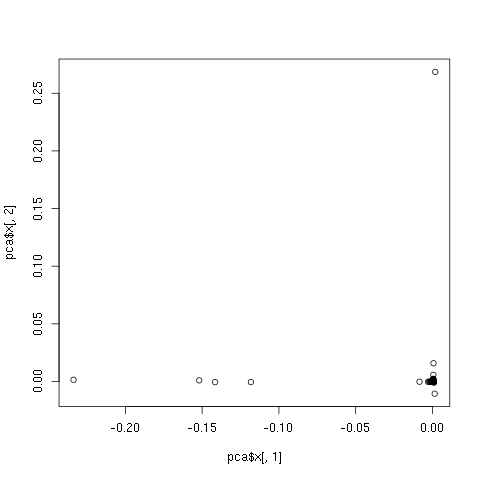

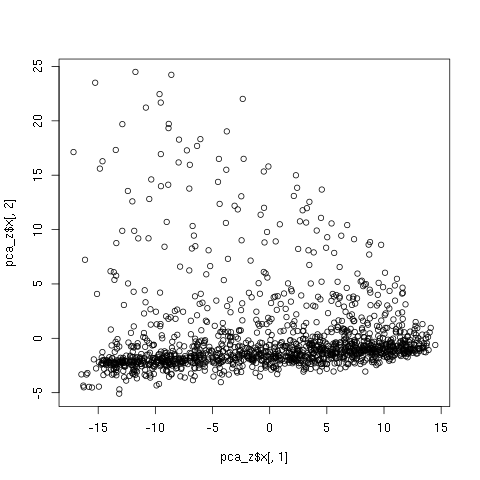

In [23]:
%%R
plot(pca$x[,1],pca$x[,2])
plot(pca_z$x[,1],pca_z$x[,2])

### HIP

In [24]:
%%R
HIP_top1000_leven1=read.table("/home/taumata/COV_AdaptiveBiotech/AB_prediction/HIP_freq_of_top1000_leven1_v2.tsv",
                            sep="\t",header=TRUE)


In [28]:
%%R
HIP_top1000_leven1_z=data.frame(t(apply(HIP_top1000_leven1,1,z)))
pca=prcomp(HIP_top1000_leven1)
pca_z=prcomp(HIP_top1000_leven1_z)

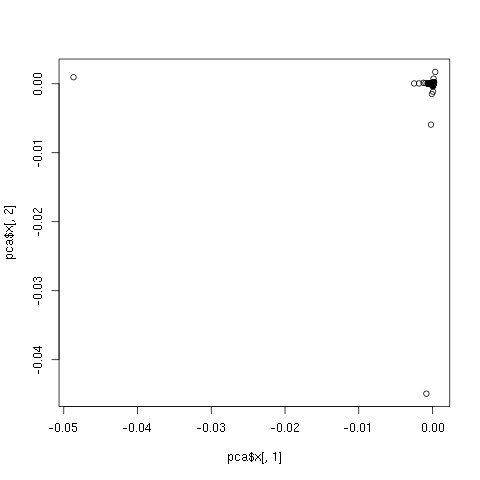

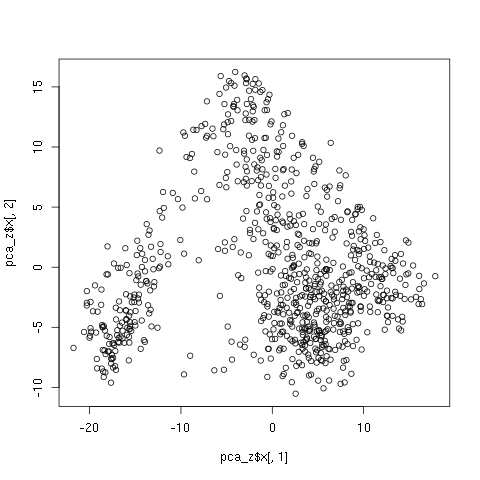

In [30]:
%%R
plot(pca$x[,1],pca$x[,2])
plot(pca_z$x[,1],pca_z$x[,2])

### FMBA

In [31]:
%%R
#read clonotypes data
FMBA_data=read.table("/home/taumata/COV_AdaptiveBiotech/AB_prediction/FMBA_freq_of_top1000_leven1_v2.tsv",
                            sep="\t",header=TRUE)


In [32]:
%%R
#read metadata
FMBA_metadata=read.table("/projects/fmba_covid/metadata_fmba_full.txt",sep="\t",header=TRUE)


In [35]:
%%R
table(FMBA_metadata[,"sample.COVID_status"])


                                current               early             healthy 
                  5                 410                  22                 472 
               past undiagnosed disease 
                330                  11 


In [55]:
%%R
table(apply(FMBA_data,1,sum)>0)


FALSE  TRUE 
    6  1025 


In [56]:
%%R
#six samples do not have any of specific clonotypes, remove them for somme time
FMBA_data=FMBA_data[apply(FMBA_data,1,sum)>0,]

In [57]:
%%R
#just stupid way to subsample and reorder samples
FMBA_current=FMBA_data[rownames(FMBA_data) %in% FMBA_metadata[FMBA_metadata$sample.COVID_status=="current",]$id,]
FMBA_healthy=FMBA_data[rownames(FMBA_data) %in% FMBA_metadata[FMBA_metadata$sample.COVID_status=="healthy",]$id,]
FMBA_past=FMBA_data[rownames(FMBA_data) %in% FMBA_metadata[FMBA_metadata$sample.COVID_status=="past",]$id,]


In [59]:
%%R
FMBA_top1000_all=rbind(FMBA_current, FMBA_healthy)
FMBA_top1000_all=rbind(FMBA_top1000_all, FMBA_past)   
FMBA_top1000_all_z=data.frame(t(apply(FMBA_top1000_all,1,z)))
pca=prcomp(FMBA_top1000_all)
pca_z=prcomp(FMBA_top1000_all_z)
colors=c(rep("red",  dim(FMBA_current)[1]),
         rep("green",dim(FMBA_healthy)[1]),
         rep("blue", dim(FMBA_past)[1]))
         

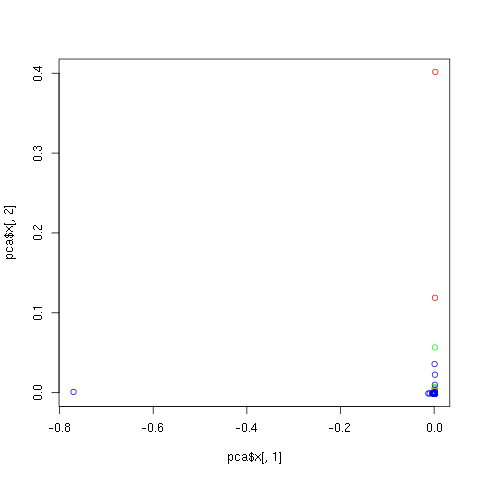

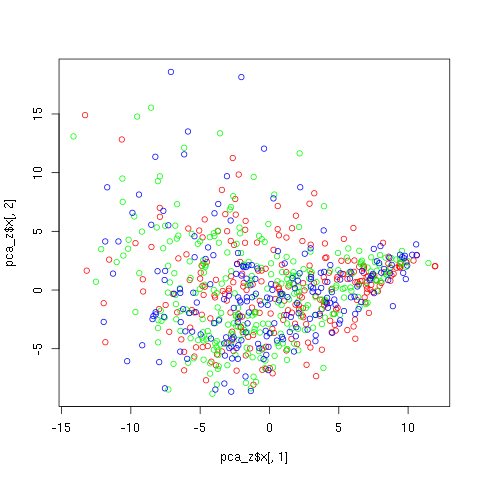

In [60]:
%%R
plot(pca$x[,1],pca$x[,2],col=colors)
plot(pca_z$x[,1],pca_z$x[,2],col=colors)


### Adaptive and HIP

In [70]:
adaptive_acute_list=list(adaptive_acute)
adaptive_recovered_list=list(adaptive_recovered)

In [71]:
%%R -i adaptive_acute_list -i adaptive_recovered_list
AB_top1000_leven1_z_acute=AB_top1000_leven1_z[rownames(AB_top1000_leven1_z) %in% adaptive_acute_list,]
AB_top1000_leven1_z_recovered=AB_top1000_leven1_z[rownames(AB_top1000_leven1_z) %in% adaptive_recovered_list,]

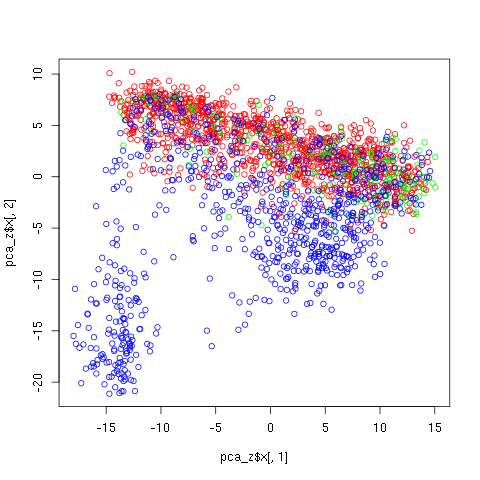

In [72]:
%%R
AB_and_HIP_top1000_leven1_z=rbind(AB_top1000_leven1_z_acute, AB_top1000_leven1_z_recovered)
AB_and_HIP_top1000_leven1_z=rbind(AB_and_HIP_top1000_leven1_z, HIP_top1000_leven1_z)

colors=c(rep("red",dim(AB_top1000_leven1_z_acute)[1]),
         rep("green",dim(AB_top1000_leven1_z_recovered)[1]),
         rep("blue",dim(HIP_top1000_leven1_z)[1]))
pca_z=prcomp(AB_and_HIP_top1000_leven1_z)
plot(pca_z$x[,1],pca_z$x[,2],col=colors)
#text(pca_z$x[,1],pca_z$x[,2],labels=rownames(pca_z$x))
#BLUE - HIP, RED - ADAPTIVE, GREEN - RECOVERED

### All together

In [62]:
%%R
all_top_1000=rbind(FMBA_top1000_all,AB_top1000_leven1)
all_top_1000=rbind(all_top_1000,HIP_top1000_leven1)
all_top_1000_z=data.frame(t(apply(all_top_1000,1,z)))
pca=prcomp(all_top_1000)
pca_z=prcomp(all_top_1000_z)
colors=c(rep("red",  dim(FMBA_current)[1]),
         rep("green",dim(FMBA_healthy)[1]),
         rep("blue", dim(FMBA_past)[1]),
         rep("orange", dim(AB_top1000_leven1)[1]),
         rep("black", dim(HIP_top1000_leven1)[1]))
         

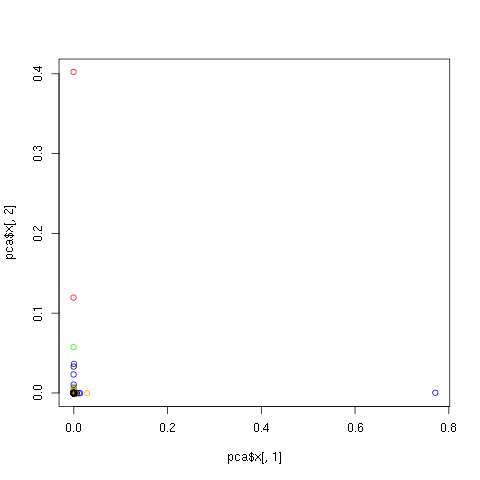

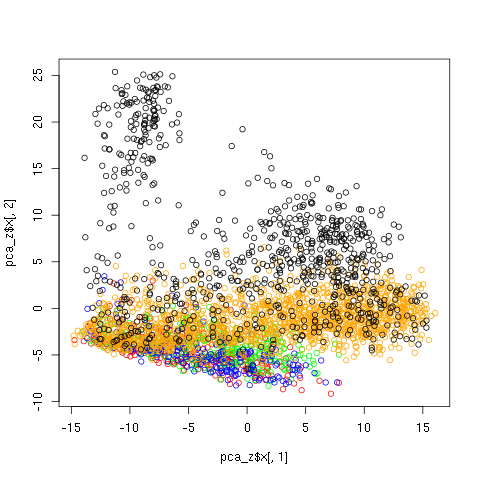

In [63]:
%%R
plot(pca$x[,1],pca$x[,2],col=colors)
plot(pca_z$x[,1],pca_z$x[,2],col=colors)



### PCA on presence/absence

In [64]:
%%R
all_top_1000_absence=all_top_1000
all_top_1000_absence[all_top_1000_absence>0]=1
pca=prcomp(all_top_1000_absence)
colors=c(rep("red",  dim(FMBA_current)[1]),
         rep("green",dim(FMBA_healthy)[1]),
         rep("blue", dim(FMBA_past)[1]),
         rep("orange", dim(AB_top1000_leven1)[1]),
         rep("black", dim(HIP_top1000_leven1)[1]))
         

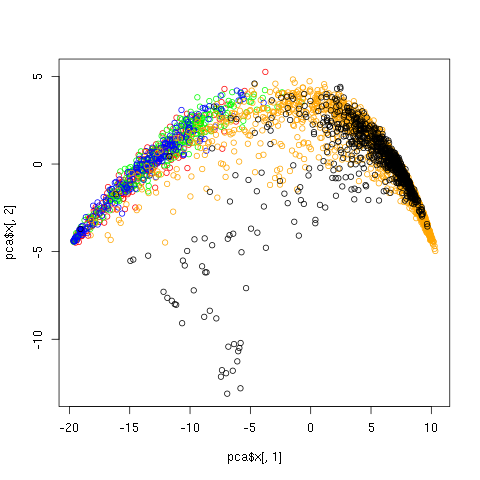

In [65]:
%%R
#PC1 and PC2
plot(pca$x[,1],pca$x[,2],col=colors)

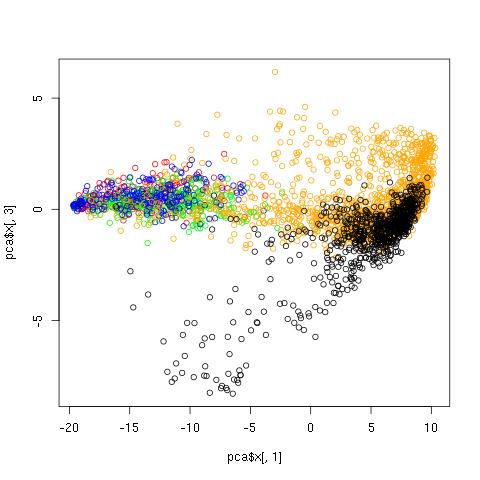

In [69]:
%%R
#PC1 and PC3
plot(pca$x[,1],pca$x[,3],col=colors)